# 実行コマンド

In [7]:
#run preparation

In [20]:
# run re-calculation

# 基本部分

In [2]:
from control import matlab
from matplotlib import pyplot as plt
import japanize_matplotlib
import numpy as np
from scipy import linalg as LA


class systemd:
    def __init__(self, A, B, E, C, Ts):
        br, bc = B.shape
        cr, cc = C.shape
        sys1 = matlab.ss(A, B, C, np.zeros((cr, bc)))
        sys1d = matlab.c2d(sys1, Ts)
        br, bc = E.shape
        cr, cc = C.shape
        sys2 = matlab.ss(A, E, C, np.zeros((cr, bc)))
        sys2d = matlab.c2d(sys2, Ts)
        self.A = sys1d.A
        self.B = sys1d.B
        self.E = sys2d.B
        self.C = sys1d.C
        
    def update(self, x1, u1, d1):
        x2 = self.A.dot(x1) + self.B.dot(u1) + self.E.dot(d1)
        y2 = self.C.dot(x1)
        return x2, y2
    
class mycontrol:
    """
    離散システム用
    y(k+1) = Ad*x(t) + Bd*u(k) + Ed*d(k) 想定
    """
            
    def ss(A, B, E, C, Ts):
        return systemd(A, B, E, C, Ts)
    
    def lqrd(A, B, Q, R):
        """
        離散系最適レギュレータ
        """
        P = LA.solve_discrete_are(A, B, Q, R)
        K = LA.inv(R+B.T.dot(P).dot(B)).dot(B.T).dot(P).dot(A)
        E = None
        
        return P, K, E
    
def rmse(en, gn, mes=None):
    if mes!=None:
        print(mes)
    for i in range(len(en)):
        e, g = en[i], gn[i]
        n = e.shape[0]
        print(g, np.sqrt(np.sum(e*e)/n))

# パラメータ

In [61]:
# run re_calc

In [17]:
# 入力値
m = 534 # 車体重量 kg
Is = 785 # 車体の慣性モーメント kg*m^2
kf = 13569 # 前輪支持ばね定数 N/m
kr = 17681 # 後輪支持ばね定数 N/m
cf = 1200 # 前輪支持減衰定数 Ns/m
cr = 1299 # 後輪支持減衰定数 Ns/m
a = 1.2 # 車体重心と前輪軸間距離 mb
b = 1.3 # 車体重心と後輪軸間距離 m

Ts = 0.001 # サンプリング周期 sec
hd = 0.08 # 外乱高さ m
ld = 0.5 # 外乱長さ m
dl = 5 # 外乱までの距離 m

h = np.array([1, 1])*10**-8 # 重み行列H用 1x2

Cp = np.array(
    [
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ]
)

# 計算値
l = a+b  # ホイールベース間距離 m
H = np.diag(h)  # 重み行列H 2x2

Ap = np.array(
    [
        [0, 1, 0, 0],
        np.array([-(kf+kr), -(cf+cr), kf*a-kr*b, cf*a-cr*b])/m,
        [0, 0, 0, 1],
        np.array([kf*a-kr*b, cf*a-cr*b, -(kf*a*a+kr*b*b), -(cf*a*a+cr*b*b)])/Is
    ]
)
Bp = np.array(
    [
        [0, 0],
        [1/m, 1/m],
        [0, 0],
        [-a/Is, b/Is]
    ]
)
Ep = np.array(
    [
        [0, 0, 0, 0],
        np.array([kf, cf, kr, cr])/m,
        [0, 0, 0, 0],
        np.array([-kf*a, -cf*a, kr*b, cr*b])/Is
    ]
)

# 外乱

In [ ]:
# run re_calc

In [18]:
def w_dist(x):
    if x<= l:
        return 0
    elif x<= l+ld:
        return hd*(1-np.cos(2*np.pi*(x-l)/ld))/2
    else:
        return 0
    
def w_distd(x):
    xd = x%(l+ld+2.5)
    if xd<= l:
        return 0
    elif xd<= l+ld:
        return hd*(1-np.cos(2*np.pi*(xd-l)/ld))/2
    else:
        return 0
    
def dist(x, l):
    return w_dist(x+l), w_dist(x)

# sim2 加速度一定

## 追加パラメータ

In [106]:
# run re_calc

In [19]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)

start_time = 0
end_time = 0.5
t = np.arange(start_time, end_time, Ts)

# 0-100km/h : 12秒程度
# 最大の加速度=>加速度 : 8.5km/h程度
# 加速度 6km/s^2 と仮定
start_v = 30
ac_v = 6
# ac_v = -6
vs = start_v*1000/3600
ac = ac_v*1000/3600

q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

In [31]:
t.size

500

## 本体

In [22]:
num = 4
xn = np.zeros((num, t.size, 4, 1)) # 状態変数
yn = np.zeros((num, t.size, 2, 1)) # 出力
un = np.zeros((num, t.size, 2, 1)) # 入力
dis = np.zeros((t.size)) # 距離
d = np.zeros((t.size, 4, 1)) # 外乱
en = np.zeros((num, t.size, 2, 1)) # エラー
yokenn = np.zeros((num, t.size, step, 4, 1))
ean = np.zeros((num, t.size)) # 予見情報平均誤差率

# 移動距離と外乱を先に計算
for i in range(t.size-1):
    dis[i+1] = vs*i*Ts + ac*i*i*Ts*Ts/2
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts

v = vs # 速度
for i in range(t.size-1):
    for n in range(num):
        x, y, u, e, yoken = xn[n], yn[n], un[n], en[n], yokenn[n]
        # 処理部
        x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
        
        # Non preview (n=0)
        e[i+1], dx = -y[i+1], x[i+1] - x[i]
        du = Fe.dot(e[i+1]) + Fx.dot(dx)
        
        
        # Preview True (n=1)
        if n==1:
            for j in range(step):
                k = i+j
                if k>0 and k<t.size-1:
                    yoken[i+1][j][2:] = d[k+1][2:] - d[k][2:]
                    
        # Preview 速度一定 (n=2)
        if n==2:
            s = int(l/(v*Ts)+0.5)
            for j in range(step):
                k = i+j-s
                if k>0 and k<t.size-1:
                    yoken[i+1][j][2:] = d[k+1][:2] - d[k][:2]
                    
        # Preview mod1 加速度一定 (n=3)
        if n==3:
            for j in range(step):
                ys = v + ac*j*Ts
#                 s = int((-ys+np.sqrt(ys*ys+2*ac*l))/(ac*Ts))
                s = int((ys-np.sqrt(ys*ys - 2*ac*l))/(ac*Ts)+0.5)
                k = i+j-s
                if k>0 and k<t.size-1:
                    yoken[i+1][j][2:] = d[k+1][:2] - d[k][:2]
                    
        for j in range(step):
            du += Fd[j].dot(yoken[i+1][j])
        u[i+1] = u[i] + du
        # 処理部終わり
        xn[n], yn[n], un[n], en[n], yokenn[n] = x, y, u, e, yoken
        
    v = vs + ac*(i+1)*Ts
    ac += 0.0005
    
read = (0, 1, 2, 3)
yn = list()
gn = list()
for i in read:
    yn.append(yokenn[i][:,3]-yokenn[1][:,3])
    gn.append(glist[i])

mes = '予見情報'
rmse(yn, gn, mes)
print('(v, a) = ({0}, {1})'.format(v*3600/1000, ac*3600/1000))

予見情報
non pre 0.11682600807893571
preT 0.0
pre 0.12701680676508503
pre m1 0.027331111558695286
(v, a) = (33.441303599999955, 6.8981999999999015)


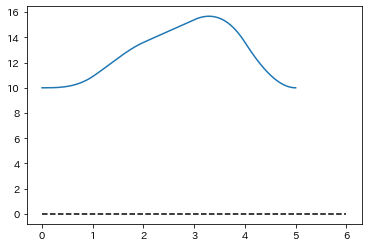

In [335]:
(0.0005)*3600/(1000*Ts)
plt.figure()
plt.plot(t, vfig)
plt.hlines([0], st, et, linestyles='dashed')

# plot

In [321]:
# run plot2

In [21]:
glist = ('non pre', 'preT', 'pre', 'pre m1')

## 状態変数x

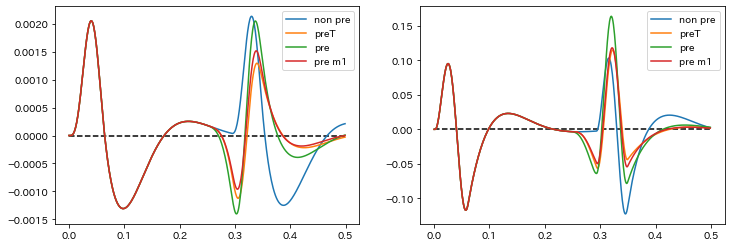

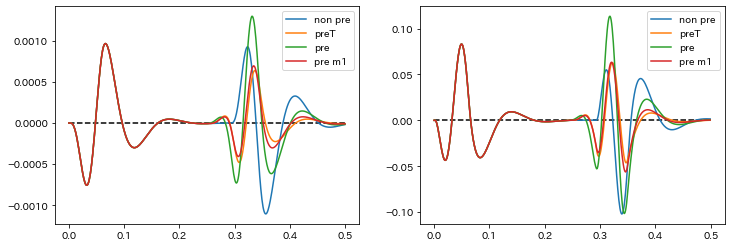

In [105]:
# 状態変数x
read = (0, 1, 2, 3)
st, et = 0, end_time

std, etd = int(st/Ts), int(et/Ts)
yn = list()
gn = list()
for i in read:
    yn.append(xn[i][std:etd])
    gn.append(glist[i])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

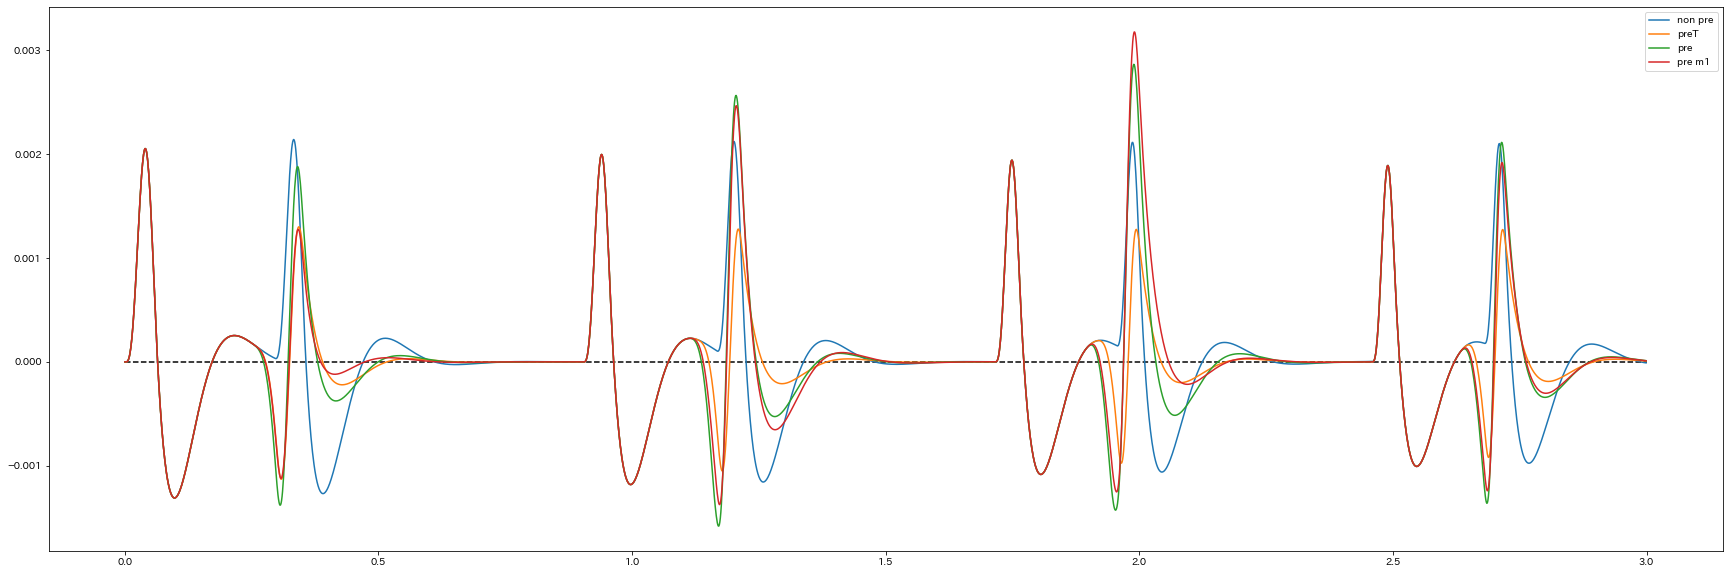

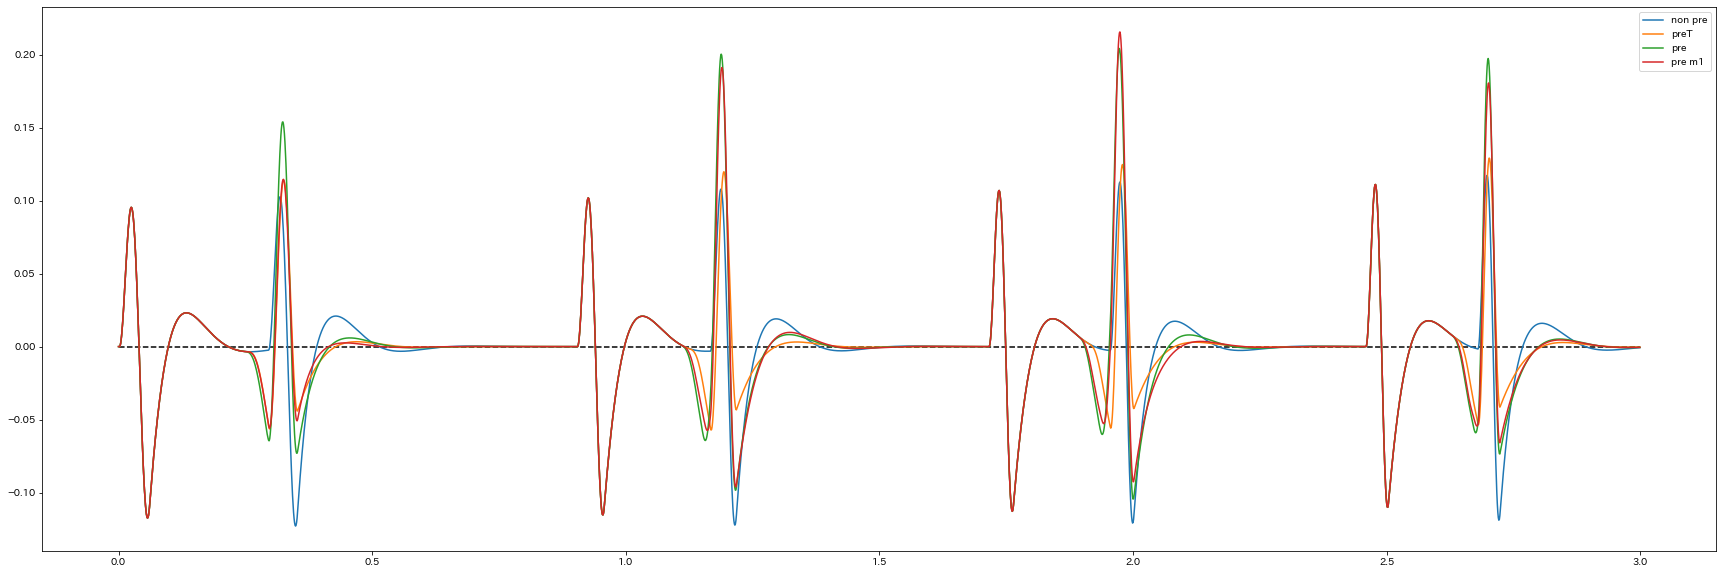

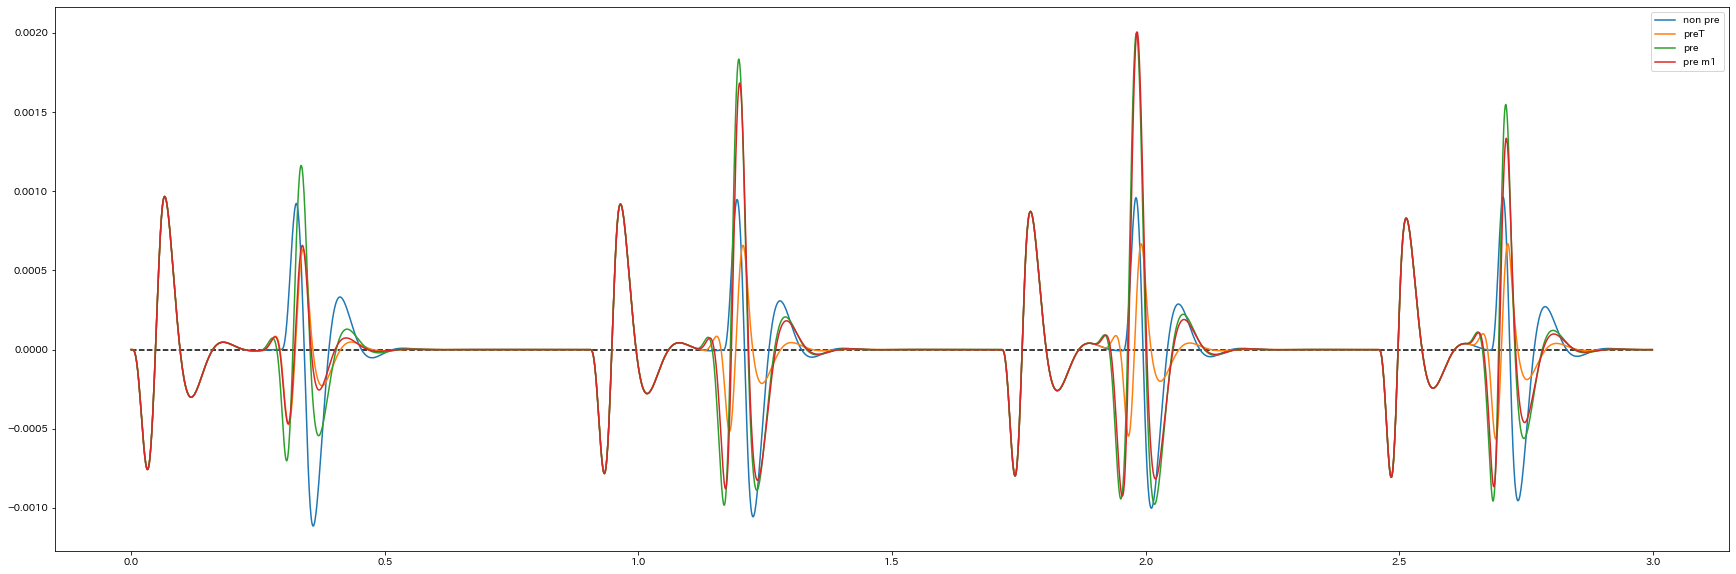

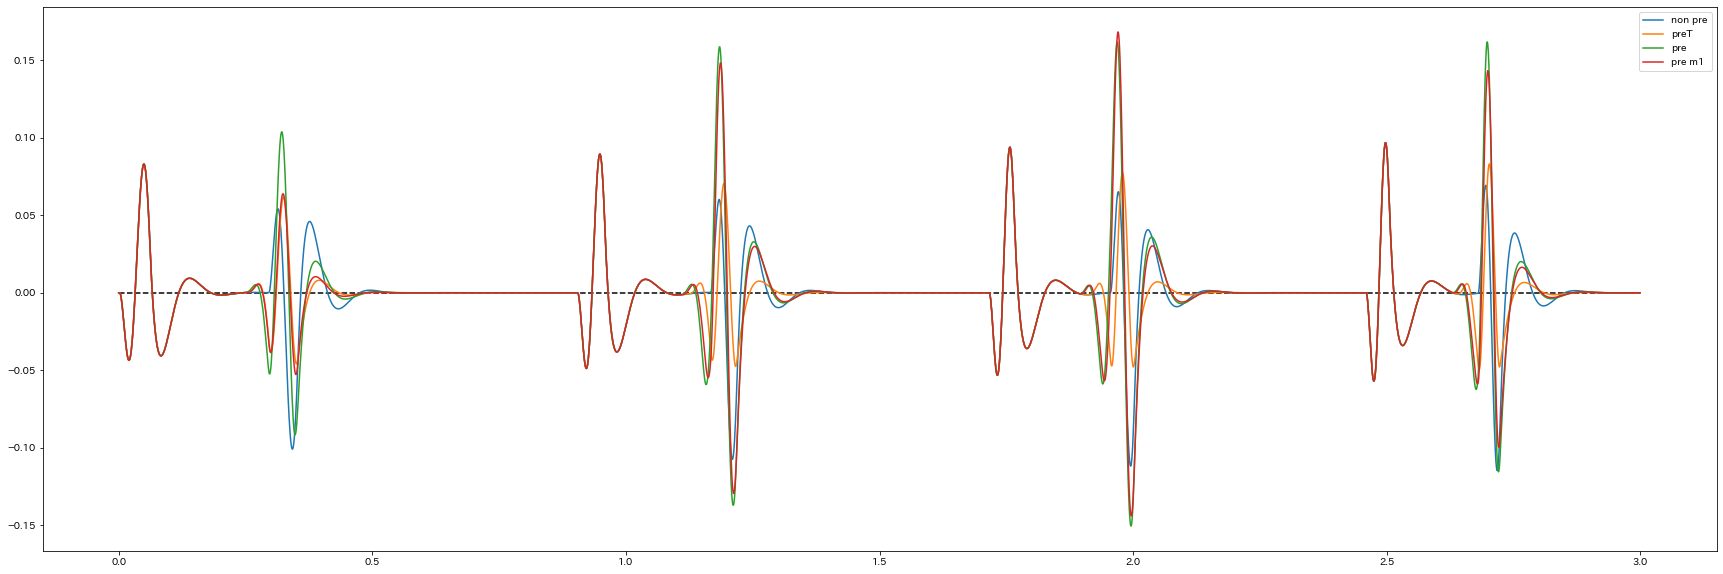

In [189]:
# 状態変数x
read = (0, 1, 2, 3)
st, et = 0, end_time

std, etd = int(st/Ts), int(et/Ts)
yn = list()
gn = list()
for i in read:
    yn.append(xn[i][std:etd])
    gn.append(glist[i])

fsize=(30, 10)

plt.figure(figsize=fsize)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.figure(figsize=fsize)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.figure(figsize=fsize)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.figure(figsize=fsize)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

## 入力u

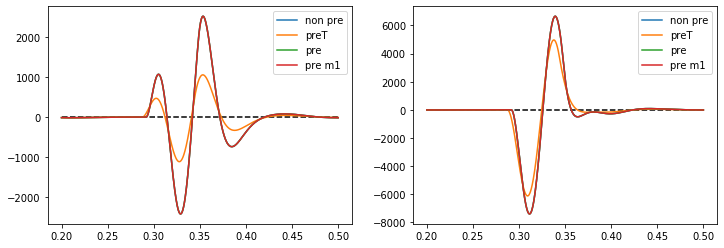

In [90]:
# 入力u
read = (0, 1, 2, 3)
st, et = 0.2, end_time

std, etd = int(st/Ts), int(et/Ts)
yn = list()
gn = list()
for i in read:
    yn.append(un[i][std:etd])
    gn.append(glist[i])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

In [184]:
un[i][200:].shape
yn[0][:,0].shape

(300, 1)

## 外乱d

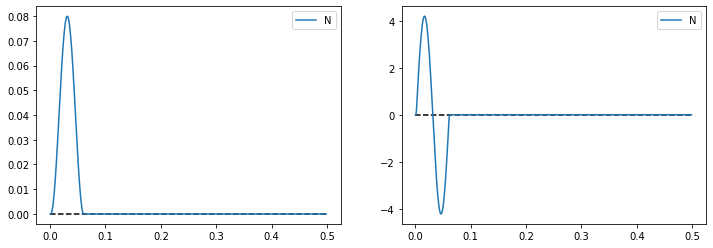

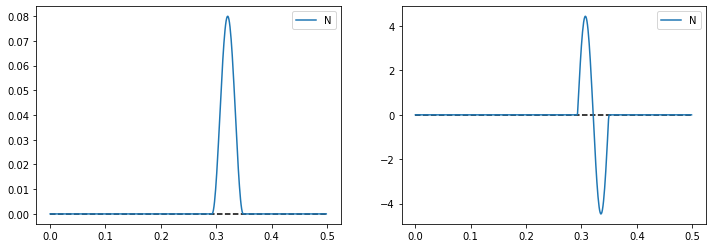

In [319]:
# 外乱d
read = (0, 1, 2, 3)
st, et = 0, end_time

std, etd = int(st/Ts), int(et/Ts)
yn = (d[std:etd],)
gn = ('None')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], st, et, linestyles='dashed')

## 距離dis

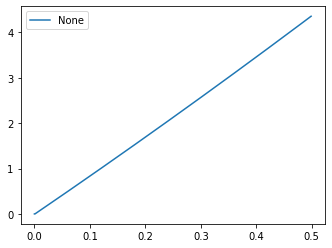

In [320]:
# 距離dis
read = (0, 1, 2, 3)
st, et = 0, end_time

std, etd = int(st/Ts), int(et/Ts)
yn = (dis[std:etd],)
gn = ('None',)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t[std:etd], yn[i], label=gn[i])
plt.legend()

# 平均誤差率

In [534]:
read = (0, 1, 2, 3)

yn = list()
gn = list()
for i in read:
    yn.append(un[i][:, 0])
    gn.append(glist[i])

mes = '入力-前輪'
rmse(yn, gn, mes)

入力-前輪
non pre 1294.423893949244
preT 1221.1424723088908
pre 1250.4669088705498
pre m1 1224.1413532494375


In [535]:
read = (0, 1, 2, 3)

yn = list()
gn = list()
for i in read:
    yn.append(un[i][:, 1])
    gn.append(glist[i])

mes = '入力-後輪'
rmse(yn, gn, mes)

入力-後輪
non pre 1420.6635440314833
preT 716.1854323923787
pre 929.0132761230775
pre m1 740.5871387524811


In [561]:
read = (0, 1, 2, 3)

yn = list()
gn = list()
for i in read:
    yn.append(xn[i][:, 0]*100)
    gn.append(glist[i])

mes = '車体上下変位'
rmse(yn, gn, mes)

車体上下変位
non pre 0.04704255894587731
preT 0.039156182635680346
pre 0.04411376953094152
pre m1 0.06820501506572091


In [569]:
read = (0, 1, 2, 3)

yn = list()
gn = list()
for i in read:
    yn.append(yokenn[i][:,2]-yokenn[1][:,2])
    gn.append(glist[i])

mes = '予見情報'
rmse(yn, gn, mes)

予見情報
non pre 0.24891262906472594
preT 0.0
pre 0.3476375253294076
pre m1 0.0482756817843206


In [370]:
yn[0].shape

(500, 43, 4, 1)

# グラフ出力

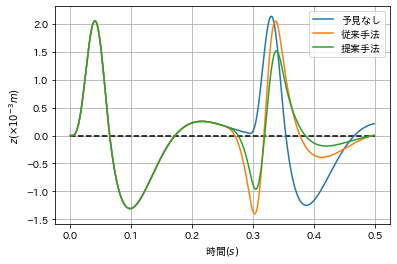

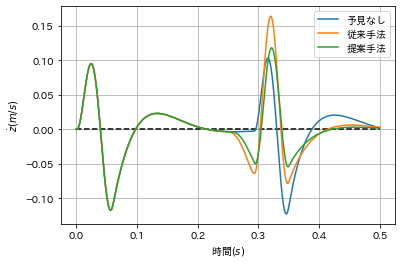

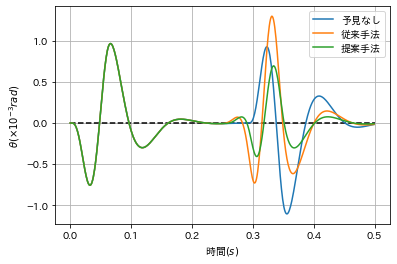

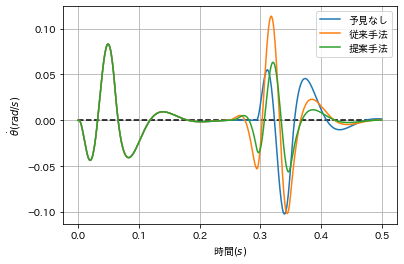

In [23]:
# 状態変数x
yn = (xn[0], xn[1], xn[2], xn[3])
gn = ('予見なし', '理想的予見', '従来手法', '提案手法')
nn = (0, 2, 3)
name='sim2'

fig = plt.figure()
for i in nn:
    plt.plot(t, yn[i][:, 0]*10**3, label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$z(\times 10^{-3} m)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_x0.png'.format(name))

fig = plt.figure()
for i in nn:
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$\dot{z}(m/s)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_x1.png'.format(name))

fig = plt.figure()
for i in nn:
    plt.plot(t, yn[i][:, 2]*10**3, label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$\theta(\times 10^{-3} rad)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_x2.png'.format(name))

fig = plt.figure()
for i in nn:
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$\dot{\theta}(rad/s)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_x3.png'.format(name))

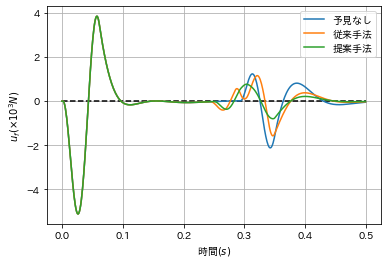

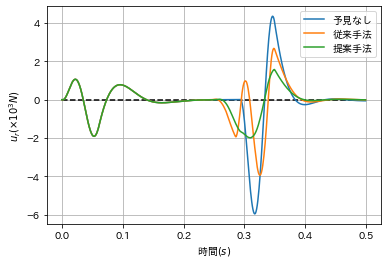

In [24]:
# 入力
yn = (un[0], un[1], un[2], un[3])
gn = ('予見なし', '理想的予見', '従来手法', '提案手法')
nn = (0, 2, 3)
name='sim2'

fig = plt.figure()
for i in nn:
    plt.plot(t, yn[i][:, 0]/10**3, label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$u_f(\times 10^{3} N)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_u0.png'.format(name))

fig = plt.figure()
for i in nn:
    plt.plot(t, yn[i][:, 1]/10**3, label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$u_r(\times 10^{3} N)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_u1.png'.format(name))

## sim4

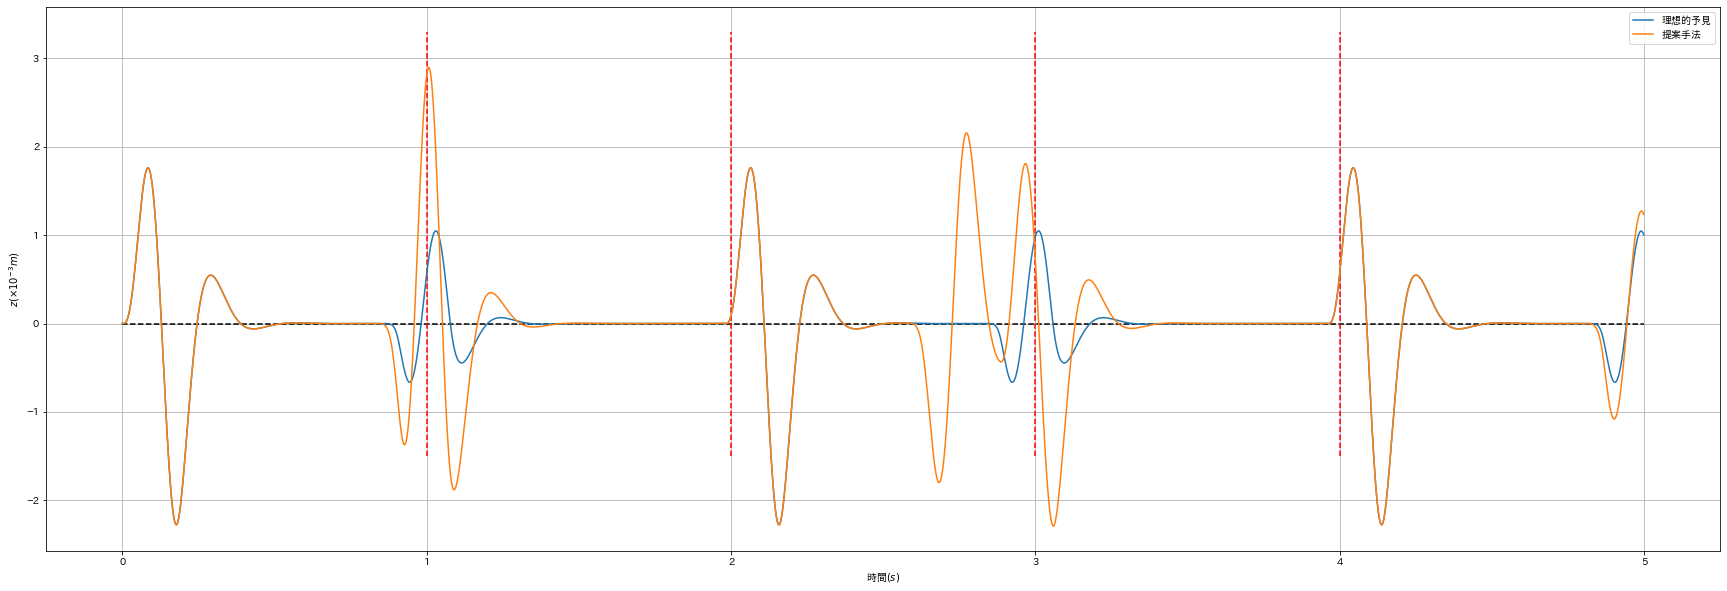

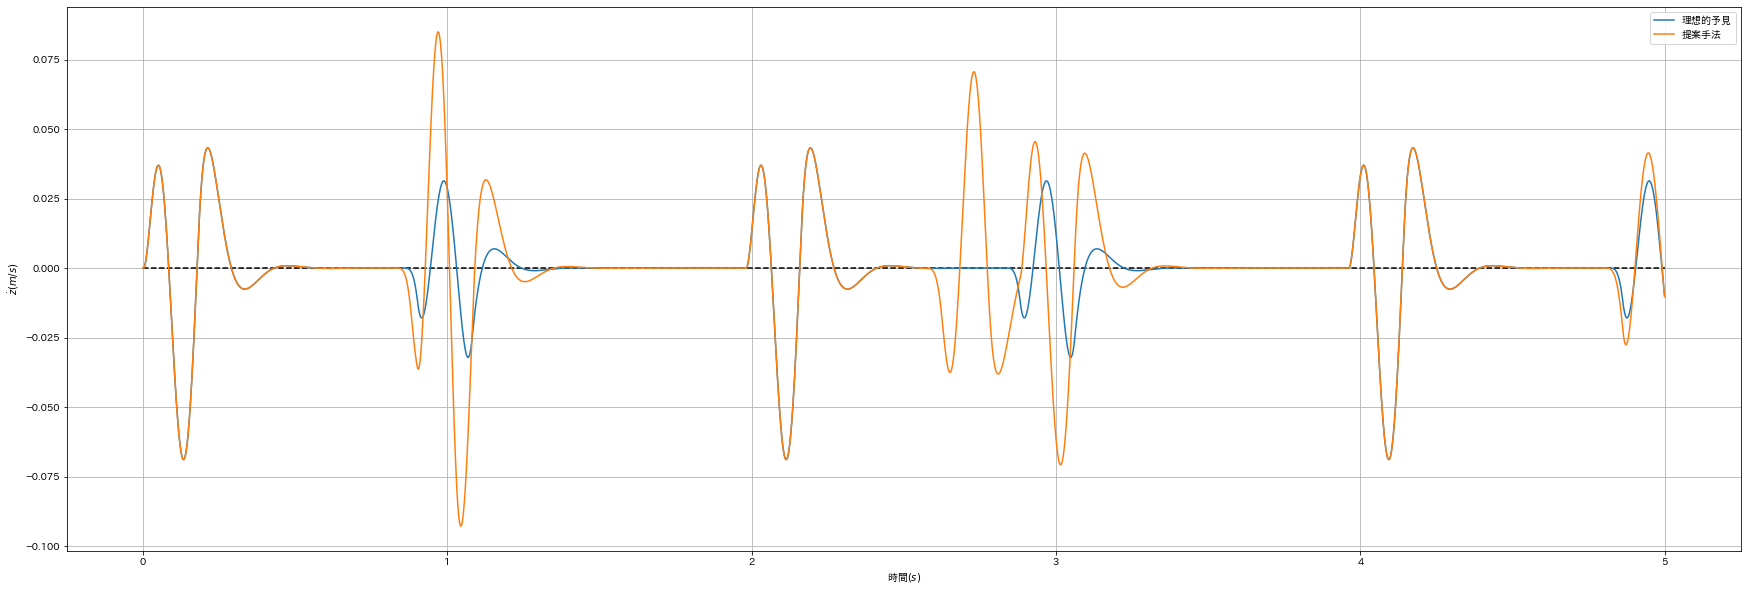

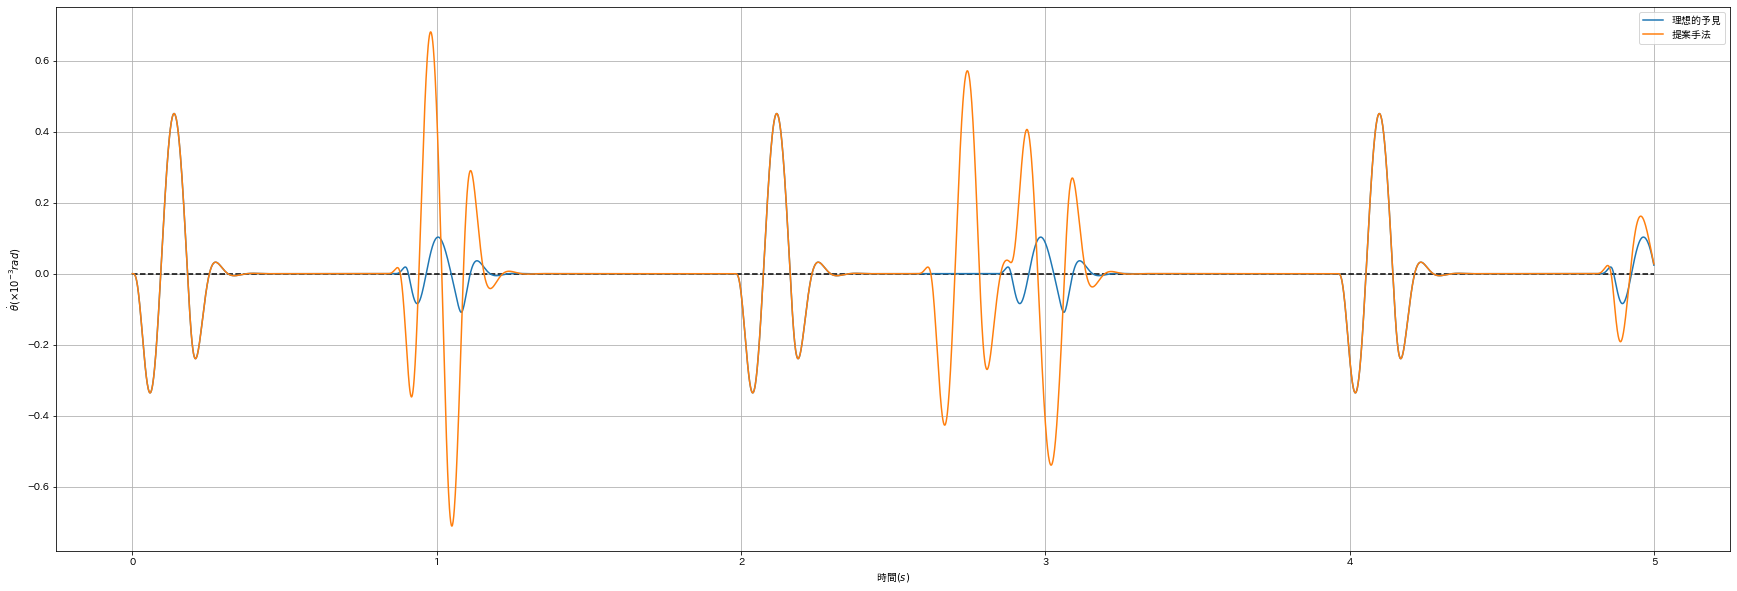

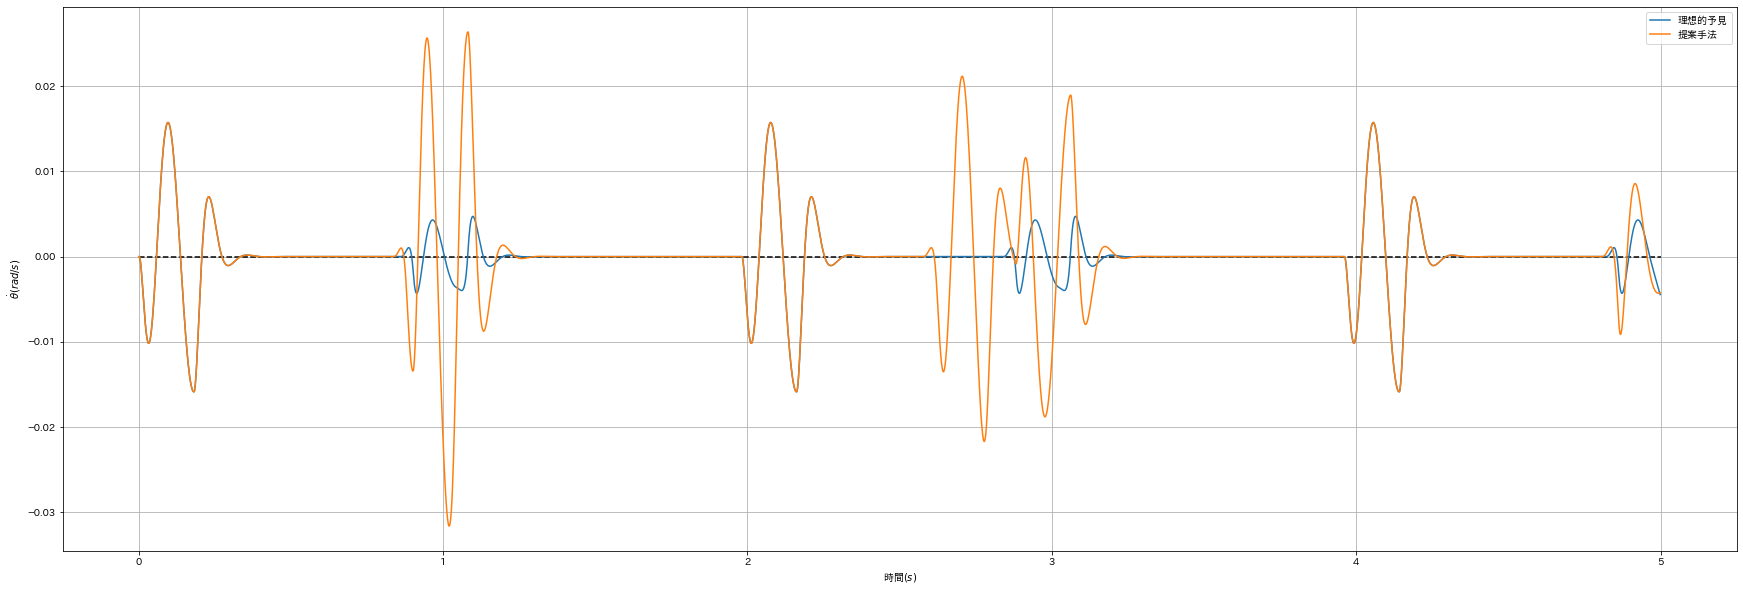

In [39]:
# sim4専用
# 状態変数x
yn = (xn[0], xn[1], xn[2], xn[3])
gn = ('予見なし', '理想的予見', '従来手法', '提案手法')
nn = (1, 3)
name='sim5'
fsize=(30, 10)

fig = plt.figure(figsize=fsize)
for i in nn:
    plt.plot(t, yn[i][:, 0]*10**3, label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.vlines([1, 2, 3, 4], -1.5, 3.3, "red", linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$z(\times 10^{-3} m)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_x0.png'.format(name))

fig = plt.figure(figsize=fsize)
for i in nn:
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$\dot{z}(m/s)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_x1.png'.format(name))

fig = plt.figure(figsize=fsize)
for i in nn:
    plt.plot(t, yn[i][:, 2]*10**3, label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$\dot{\theta}(\times 10^{-3} rad)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_x2.png'.format(name))

fig = plt.figure(figsize=fsize)
for i in nn:
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.xlabel(r'時間$(s)$')
plt.ylabel(r'$\dot{\theta}(rad/s)$')
plt.grid()
plt.legend()
fig.savefig('sim/{0}_x3.png'.format(name))